In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys, os
# import options_parser as op
import numpy as np
import torch
import random
import train
from torch.utils.data import Dataset, DataLoader
from dataloader import get_loaders, GeneVecs
import argparse
import model
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
import umap


In [3]:
SEED = 459
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
save_dir = './data/model'
batch_size = 64
input_size = 704

In [11]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir) 
train_loader, val_loader, test_loader, input_size, train_set = get_loaders('../data/CCLE_expression_final.csv', '../data/GCG_filter_indx.txt', batch_size)

GE_DF LOADED!


In [5]:
train.train_network(train_loader, val_loader, save_dir, input_size)

INPUT SIZE (number of genes):  704
NUMBER OF PARAMS:  1443520


Epoch: 99999: 100%|██████████| 100000/100000 [37:48<00:00, 44.09it/s, Train Loss=0.000186, Validation Loss=0.231, Best=0.216]


In [4]:
net = model.Net(input_size)
states = torch.load(os.path.join(save_dir,'trained_model_best.pth'))
net.load_state_dict(states['state_dict'])
net.cuda()
net.eval()

Net(
  (h1): Linear(in_features=704, out_features=1024, bias=False)
  (activation): Nonlinearity()
  (out): Linear(in_features=1024, out_features=704, bias=False)
)

In [5]:
test_loss = 0.
criterion = torch.nn.MSELoss()
laten_vectors =[]
for batch_idx, batch in enumerate(test_loader):
    inputs = Variable(batch).cuda()
    with torch.no_grad():
        output, latent = net(inputs)
        laten_vectors.append(latent.data.cpu().numpy())
    loss = criterion(output, inputs)

    test_loss += loss.cpu().data.numpy() * len(inputs)
test_loss = test_loss / len(test_loader.dataset)
laten_vectors = np.vstack(laten_vectors)
test_loss

0.2390327900648117

In [5]:
GE_df = pd.read_csv('../data/CCLE_expression_final.csv', index_col=0)

In [35]:
test_idx = np.load('./data/test_idx.npy')
with open('../data/GCG_filter_indx.txt') as f:
    filter_gene_indx = [int(s.strip()) for s in f.readlines()]
test_cell_lines = GE_df.iloc[test_idx,filter_gene_indx ]
test_cell_lines_indx = list(set(test_cell_lines.index).intersection(set(sample_info.index)))
test_cell_lines = test_cell_lines.loc[test_cell_lines_indx, ]
test_cell_lines.head()

,LASP1 (3927),HOXA11 (3207),CREBBP (1387),ETV1 (2115),GAS7 (8522),CD79B (974),PAX7 (5081),BTK (695),BRCA1 (672),WAS (7454),...,SSX2 (6757),ETV5 (2119),CEBPA (1050),LSM14A (26065),CUX1 (1523),C15orf65 (145788),NCOA4 (8031),SSX4 (6759),TAF15 (8148),MLLT6 (4302)
ACH-001239,5.796494,2.807355,3.598127,5.499208,8.439041,2.992768,0.042644,2.733354,4.750070,0.536053,...,2.994580,6.925999,0.163499,6.475896,5.075533,0.748461,5.967169,0.000000,7.437461,5.513175
ACH-000661,6.783064,1.811471,3.955127,4.944390,7.670302,3.565597,0.000000,0.367371,5.623808,0.400538,...,0.111031,6.825150,0.070389,6.367022,4.930737,1.063503,6.076602,0.070389,7.815063,4.850999
ACH-000507,6.467769,0.028569,3.808385,1.339137,2.124328,0.163499,0.014355,0.028569,4.642702,0.344828,...,0.000000,5.020147,2.891419,5.475085,5.741197,0.298658,4.311067,0.056584,7.007308,5.995258
ACH-000407,6.394548,4.005400,3.517276,3.661065,0.214125,0.111031,0.042644,0.014355,3.662205,0.275007,...,0.000000,4.254745,0.790772,5.859224,5.317594,0.941106,5.333424,0.000000,6.955359,4.823240
ACH-000499,5.479295,1.718088,3.589763,2.301588,0.773996,5.676098,3.723559,0.042644,5.024142,3.264536,...,0.545968,2.356144,4.521679,7.759422,3.508429,0.713696,4.063503,0.286881,7.260967,4.566206


In [26]:
test_cell_lines.shape

(57, 704)

In [6]:
import pandas as pd
sample_info = pd.read_csv('../data/sample_info.csv', index_col =0)

## Get the latent representation of all cell lines

In [12]:
with open('../data/GCG_filter_indx.txt') as f:
    filter_gene_indx = [int(s.strip()) for s in f.readlines()]
        
all_data_set = GeneVecs(GE_df.iloc[:, filter_gene_indx].values)
data_loader = DataLoader(all_data_set, batch_size=batch_size,
                             num_workers=0, shuffle=False,
                             pin_memory=True)

loss_ = 0.
criterion = torch.nn.MSELoss()
laten_vectors =[]
for batch_idx, batch in enumerate(data_loader):
    inputs = Variable(batch).cuda()
    with torch.no_grad():
        output, latent = net(inputs)
        laten_vectors.append(latent.data.cpu().numpy())
    loss = criterion(output, inputs)

    loss_ += loss.cpu().data.numpy() * len(inputs)
loss_ = loss_ / len(data_loader.dataset)
laten_vectors = np.vstack(laten_vectors)
loss_, laten_vectors.shape

(0.008894530702119981, (568, 1024))

In [15]:
cell_lines_encoded = sample_info.loc[GE_df.index, ['CCLE_Name','sex', 'primary_disease', 'Subtype', 'age', 'lineage', 'lineage_subtype']]
cell_lines_encoded[[f'g{i}' for i in range(laten_vectors.shape[1])]] = laten_vectors

In [20]:
reducer = umap.UMAP(random_state=42, n_neighbors=20)
embedding = reducer.fit_transform(cell_lines_encoded[[f'g{i}' for i in range(laten_vectors.shape[1])]].values)

In [21]:
cell_lines_encoded[['PC1', 'PC2']] = embedding

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

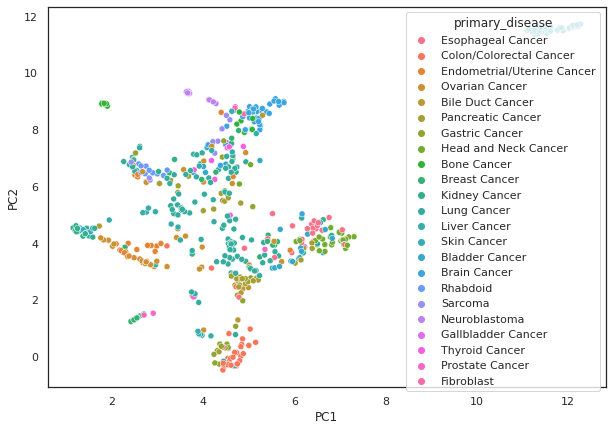

In [29]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,7)})
sns.scatterplot(x='PC1', y='PC2', hue='primary_disease', data=cell_lines_encoded)

In [24]:
cell_lines_encoded.to_csv('./data/encoded_cell_lines.csv')